Le but fondamental de ce fichier est d'explorer la relation existente entre le taux de chômage (UNRATE) et les variables explicatives ou prédicateures.

Il est primordial pour essayer d'orienter nos modèles. 

# Packages

In [27]:
import pandas as pd
from matplotlib.pyplot import subplots
import seaborn as sns

# Importer les données

In [ ]:
df_stationary_train = pd.read_csv("df_stationary_train.csv", index_col="date")


# Etude de corrélation entre le Target et les predicators

In [ ]:
cols = df_stationary_train.columns.to_list()

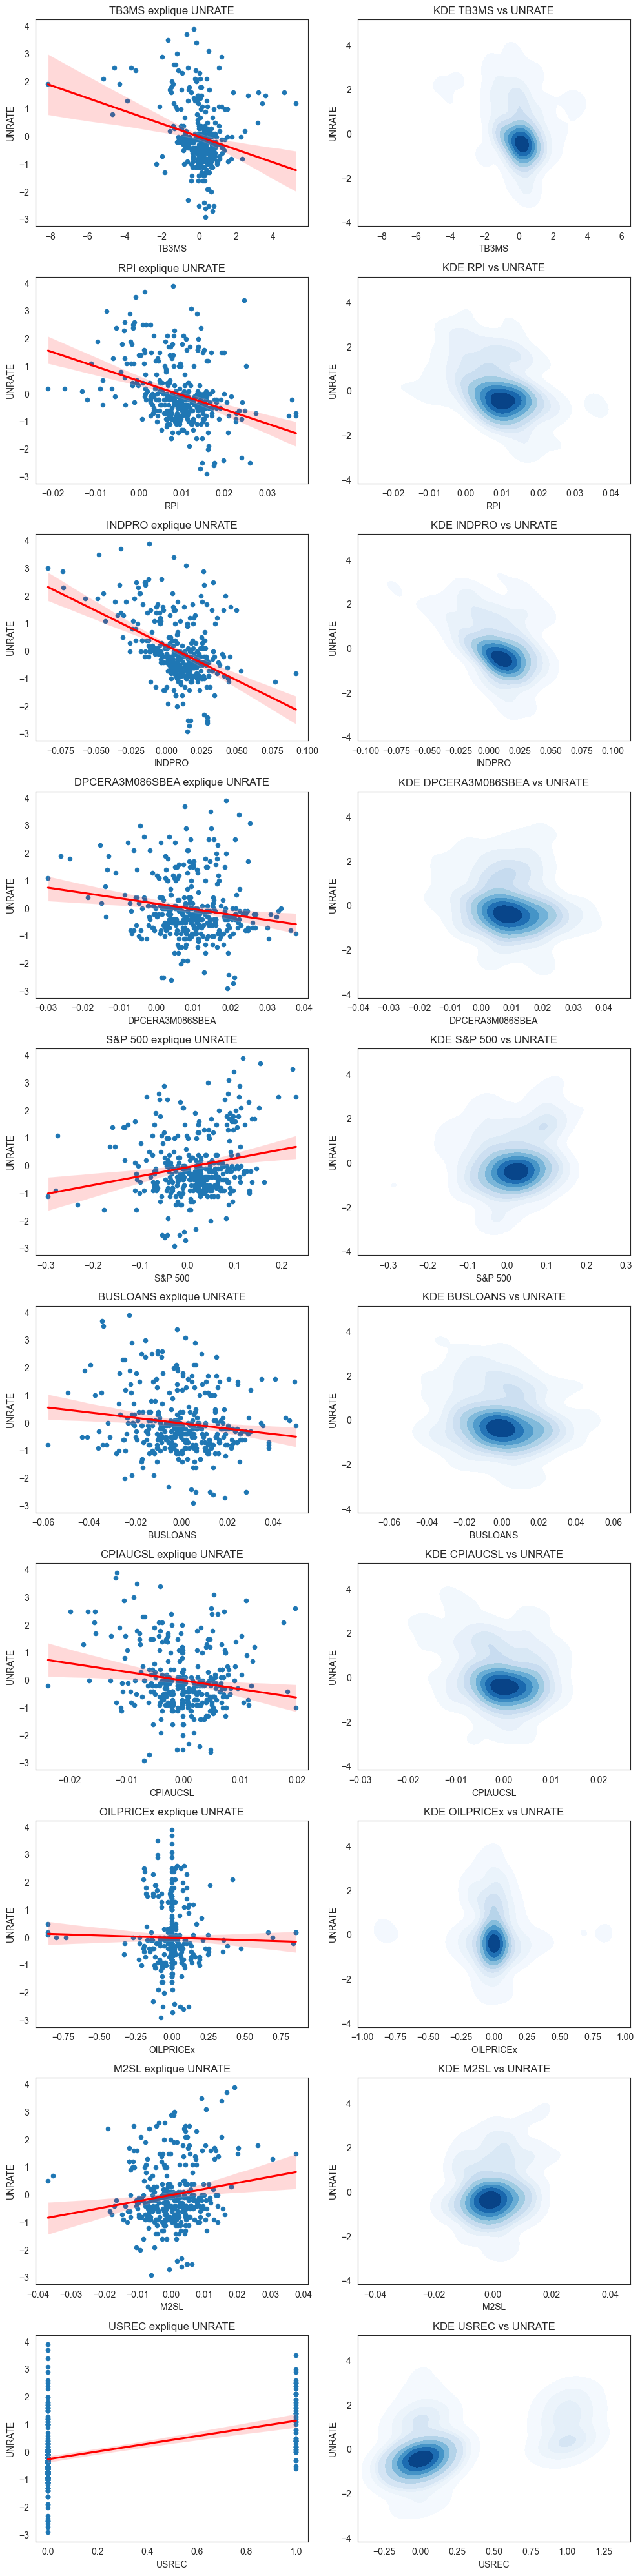

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("white")  # optionnel : style clair

fig, axes = plt.subplots(nrows=len(cols), ncols=2, figsize=(10, 4*len(cols)))

for ax_row, col in zip(axes, cols):
    ax_scatter, ax_kde = ax_row

    # === SCATTER + REGRESSION ===
    df_stationary_train.plot.scatter(x=col, y="UNRATE", ax=ax_scatter, color="tab:blue")
    sns.regplot(
        data=df_stationary_train, x=col, y="UNRATE",
        ax=ax_scatter, scatter_kws={'s':10}, line_kws={"color":"red"}
    )
    ax_scatter.set_title(f"{col} explique UNRATE")

    # === KDE PLOT ===
    sns.kdeplot(
        data=df_stationary_train,
        x=col, y="UNRATE",
        fill=True,
        cmap="Blues",
        ax=ax_kde
    )
    ax_kde.set_title(f"KDE {col} vs UNRATE")

plt.tight_layout()
plt.show()

✅ Règles de lecture
- Pente rouge → corrélation linéaire directionnelle
- Dispersion des points → force du signal vs bruit
- KDE en 2D → structure du nuage : 
  - allongé en diagonale → lien réel
  - rond → lien faible / nul
  - plusieurs “blobs” → régimes différents

1. Variables pro-cycliques (corrélation négative) : TB3MS, RPI, INDPRO, DPCERA3M086SBEA, BUSLOANS

- Pente rouge : négative → plus d’activité, moins de chômage.
- Dispersion : forte → signal réel mais bruité.
- KDE : légèrement allongé → relation linéaire faible mais présente.

→ Ces indicateurs suivent le cycle : quand ils montent, UNRATE baisse.

2. Variables sans lien clair ou un impact positif : CPIAUCSL, OILPRICEx, S&P500, M2SL
- KDE : rond → absence de structure directionnelle.
→ Relations instables ou nulles

# Test de corrélation

In [61]:
from scipy.stats import pearsonr, spearmanr
import pandas as pd

results = []

for col in cols:
    r_pearson, p_pearson = pearsonr(df_stationary_train[col], df_stationary_train["UNRATE"])
    r_spear, p_spear = spearmanr(df_stationary_train[col], df_stationary_train["UNRATE"])

    results.append({
        "Variable": col,
        "Pearson_r": r_pearson,
        "Pearson_pvalue": p_pearson,
        "Spearman_rho": r_spear,
        "Spearman_pvalue": p_spear
    })

df_corr_tests = pd.DataFrame(results)
df_corr_tests["Significatif (p<0.05)"] = df_corr_tests["Pearson_pvalue"] < 0.05
df_corr_tests

,Variable,Pearson_r,Pearson_pvalue,Spearman_rho,Spearman_pvalue,Significatif (p<0.05)
0,TB3MS,-0.238865,4.728572e-06,-0.249874,1.633372e-06,True
1,RPI,-0.352819,5.807669e-12,-0.369646,4.577510e-13,True
2,INDPRO,-0.445966,6.035676e-19,-0.396655,5.624164e-15,True
3,DPCERA3M086SBEA,-0.168558,1.348096e-03,-0.167706,1.427164e-03,True
4,S&P 500,0.205471,8.801234e-05,0.153077,3.644124e-03,True
5,BUSLOANS,-0.148235,4.886503e-03,-0.122131,2.063192e-02,True
6,CPIAUCSL,-0.167027,1.493134e-03,-0.136348,9.695711e-03,True
7,OILPRICEx,-0.024580,6.425212e-01,-0.032332,5.414516e-01,False
8,M2SL,0.160580,2.274929e-03,0.119167,2.394123e-02,True
9,USREC,0.475834,1.101997e-21,0.494970,1.383789e-23,True


- Il existe une corrélation linéaire entre le taux chômage et les prédicateurs. Le prix du pétrol n'y est pas exceptionnellement. Ces corrélations sont toutes inférieures à 0.5, donc assez faible. 

- La variable USREC est celle qui est le plus corrélée au taux de chôùage : corrélation positive et forte → signal conjoncturel clair (récessions).

- INDPRO et RPI ont des corrélations négatives assez fortes : quand l’activité réelle se contracte, ton indicateur varie en sens inverse.

<Axes: title={'center': 'UNRATE'}, xlabel='USREC'>

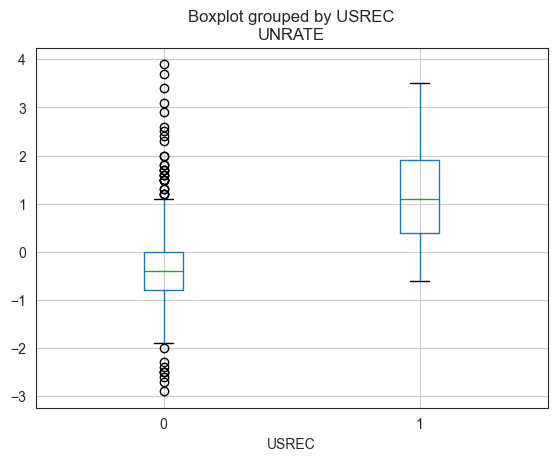

In [62]:
df_stationary_train.boxplot("UNRATE", by = "USREC")

In [63]:
from scipy.stats import f_oneway

group0 = df_stationary_train[df_stationary_train["USREC"] == 0]["UNRATE"]
group1 = df_stationary_train[df_stationary_train["USREC"] == 1]["UNRATE"]

anova = f_oneway(group0, group1)
stat, pvalue = anova.statistic, anova.pvalue

print(f"F = {stat:.4f}, p-value = {pvalue:.4f}")

# Décision
alpha = 0.05
if pvalue < alpha:
    print("👉 Décision : on rejette H0 — les moyennes sont significativement différentes.")
else:
    print("👉 Décision : on ne rejette pas H0 — pas de différence significative entre les moyennes.")

F = 104.4896, p-value = 0.0000
👉 Décision : on rejette H0 — les moyennes sont significativement différentes.


- Un modèle multivarié est utile car chaque variable économique ne fournit qu’une partie de l’information. En combinant plusieurs indicateurs, on capte mieux la réalité économique et on améliore la qualité de l’explication du chômage. On s'attend alors que les modèles multivariés prédisent mieux le taux de chômage qu'un simple modèle auto-régressive AR(). AR() est donc notre baseline. 

- On s'attend aussi que les modèles fondés sur des hypothèses de linéarité comme la régression linéaire performent moins. D'où l'intérêt d'essayer des approches en Machine Learning. Notre hypothèse est qu'ils de capturer des interactions plus subtiles et d’augmenter le potentiel prédictif.